### Importar librerias

In [59]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

### Diccionario de clases y colores

In [60]:
CLASS_COLORS = {
    (237, 34, 236): 1,  # Advertisement
    (201, 158, 74): 2,  # Field
    (96, 32, 192): 3,   # Football
    (89, 134, 179): 4,  # Goal Bar
    (153, 223, 219): 5, # Goalkeeper 1
    (255, 106, 77): 6,  # Goalkeeper 2
    (22, 100, 252): 7,  # Referee
    (143, 182, 45): 8,  # Spectators
    (38, 198, 129): 9,  # Team 1
    (27, 154, 218): 10, # Team 2
    (0, 0, 0): 0        # Background
}

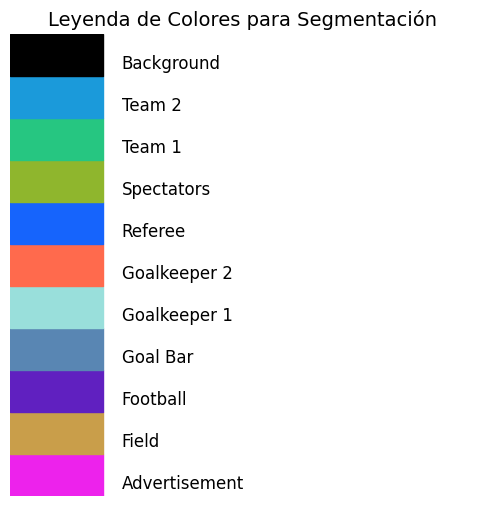

In [61]:
import matplotlib.patches as mpatches

# Diccionario con nombres de clases
CLASS_NAMES = {
    1: "Advertisement",
    2: "Field",
    3: "Football",
    4: "Goal Bar",
    5: "Goalkeeper 1",
    6: "Goalkeeper 2",
    7: "Referee",
    8: "Spectators",
    9: "Team 1",
    10: "Team 2",
    0: "Background"
}

# Crear la figura
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

# Agregar cuadros de color con nombres
for i, (color, class_idx) in enumerate(CLASS_COLORS.items()):
    rect = mpatches.Rectangle((0, i), 1, 1, color=np.array(color)/255.0)
    ax.add_patch(rect)
    ax.text(1.2, i + 0.3, f"{CLASS_NAMES[class_idx]}", fontsize=12, verticalalignment='center')

ax.set_xlim(0, 5)
ax.set_ylim(0, len(CLASS_COLORS))
ax.set_title("Leyenda de Colores para Segmentación", fontsize=14)

plt.show()

### Funcion para convertir mascara RGB a Indices

In [62]:
def convert_mask(mask, tolerance=10):
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

  for color, class_idx in CLASS_COLORS.items():
      lower_bound = np.array(color) - tolerance
      upper_bound = np.array(color) + tolerance
      mask_idx = np.all((mask >= lower_bound) & (mask <= upper_bound), axis=2)
      label_mask[mask_idx] = class_idx

  return label_mask

### Dataset de Segmentacion

In [63]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Cargar imagen y máscara
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Leer en formato RGB
        mask = convert_mask(mask)  # Convertir a índices de clase
        mask = np.array(mask, dtype=np.uint8)  # Asegurar que es un array numpy

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].clone().detach().long()

        return image, mask

### Transformaciones

In [64]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),  # Aplica la misma transformación a imagen y máscara
    A.Rotate(limit=30, p=0.5),  # Asegura que ambas roten igual
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3, border_mode=0),  # Mantiene alineación

    # SOLO para la imagen (NO afecta la máscara)
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

/home/jose/Documentos/github/semantic-segmentation/.venv/lib64/python3.13/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### Dataset y dividir en Train/Val/Test

In [65]:
dataset = SegmentationDataset(
    '../dataset/images/',
    '../dataset/masks/',
    transform=transform,
)

# Dividir en 70% entrenamiento, 15% validación, 15% prueba
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

### Visualizar y verificar transformaciones

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


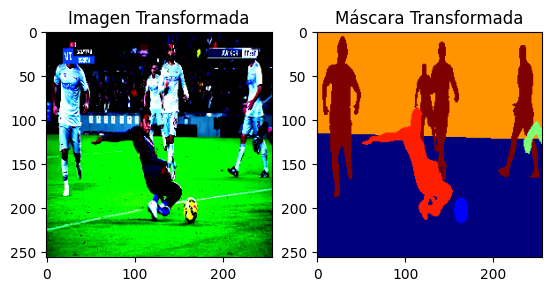

In [66]:
img, mask = dataset[0]

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Imagen Transformada")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap="jet")
plt.title("Máscara Transformada")

plt.show()

In [67]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 70
Tamaño del conjunto de validación: 15
Tamaño del conjunto de prueba: 15


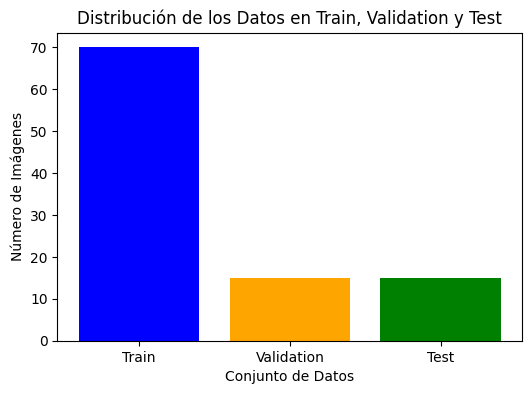

In [68]:
# Crear un gráfico de barras
datasets = ["Train", "Validation", "Test"]
counts = [len(train_dataset), len(val_dataset), len(test_dataset)]

plt.figure(figsize=(6, 4))
plt.bar(datasets, counts, color=['blue', 'orange', 'green'])
plt.xlabel("Conjunto de Datos")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de los Datos en Train, Validation y Test")
plt.show()

### Arquitectura U-Net

In [69]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):  # 11 clases (0-10)
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder = nn.ModuleList([
            conv_block(in_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
        ])

        self.bottleneck = conv_block(512, 1024)

        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ])

        self.decoder = nn.ModuleList([
            conv_block(1024, 512),
            conv_block(512, 256),
            conv_block(256, 128),
            conv_block(128, 64),
        ])

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc_features = []
        for layer in self.encoder:
            x = layer(x)
            enc_features.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        for i in range(len(self.decoder)):
            x = self.upconvs[i](x)
            enc_feature = enc_features[-(i+1)]
            x = torch.cat([x, enc_feature], dim=1)
            x = self.decoder[i](x)

        return self.final_conv(x)

### Cálculo de distribución de píxeles por clase

In [70]:
# Inicializar diccionario para contar píxeles por clase
# class_counts = defaultdict(int)

# for mask_name in os.listdir("../dataset/masks/"):
#     mask_path = os.path.join("../dataset/masks/", mask_name)
#     mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
#     mask = convert_mask(mask)  # Convertir máscara a índices de clase

#     unique, counts = np.unique(mask, return_counts=True)
#     for cls, cnt in zip(unique, counts):
#         class_counts[cls] += cnt

# # Mostrar distribución de píxeles por clase
# print("\n**Distribución de píxeles por clase:**")
# for cls, cnt in sorted(class_counts.items()):
#     print(f"Clase {cls}: {cnt} píxeles")


### Métricas para evaluación

In [71]:
# IoU (Intersection over Union)
def iou_score(preds, labels, num_classes=11, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)  # Convertir a clases

    iou_per_class = []
    for c in range(num_classes):
        pred_c = (preds == c).float()
        label_c = (labels == c).float()

        intersection = torch.sum(pred_c * label_c)
        union = torch.sum(pred_c) + torch.sum(label_c) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou.item())

    return np.mean(iou_per_class)  # Promedio de IoU por clase

# Dice Coefficient
def dice_coefficient(preds, labels, num_classes=11, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)  # Convertir a clases

    dice_per_class = []
    for c in range(num_classes):
        pred_c = (preds == c).float()
        label_c = (labels == c).float()

        intersection = torch.sum(pred_c * label_c)
        dice = (2. * intersection + smooth) / (torch.sum(pred_c) + torch.sum(label_c) + smooth)
        
        dice_per_class.append(dice.item())

    return np.mean(dice_per_class)  # Promedio de Dice por clase

# Precision, Recall y F1-Score por clase
def precision_recall_f1(preds, labels, num_classes=11):
    preds = preds.flatten()
    labels = labels.flatten()
    
    precision = precision_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    recall = recall_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    f1 = f1_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)

    return np.mean(precision), np.mean(recall), np.mean(f1)

### Configurar entrenamiento

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    best_loss = float("inf")
    patience = 5
    counter = 0

    # Guardar métricas para visualización
    train_losses, val_losses = [], []
    iou_scores, dice_scores = [], []
    precisions, recalls, f1_scores = [], [], []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        ious, dices = [], []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

                all_preds.append(torch.argmax(outputs, dim=1).cpu().numpy().flatten())
                all_labels.append(masks.cpu().numpy().flatten())

                ious.append(iou_score(outputs, masks))
                dices.append(dice_coefficient(outputs, masks))

        # Calcular métricas finales
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        precision, recall, f1 = precision_recall_f1(all_preds, all_labels, num_classes=11)

        # Guardar métricas en listas
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        iou_scores.append(np.mean(ious))
        dice_scores.append(np.mean(dices))
        precisions.append(np.mean(precision))
        recalls.append(np.mean(recall))
        f1_scores.append(np.mean(f1))

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
        print(f"   IoU: {iou_scores[-1]:.4f} | Dice: {dice_scores[-1]:.4f}")
        print(f"   Precision: {precisions[-1]:.4f}")
        print(f"   Recall: {recalls[-1]:.4f}")
        print(f"   F1-Score: {f1_scores[-1]:.4f}")

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "../models/best_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping en la época {epoch+1}")
                break

    # Retornar métricas para visualización
    return train_losses, val_losses, iou_scores, dice_scores, precisions, recalls, f1_scores

### Configurar Modelo y Entrenarlo

In [74]:
model = UNet().to(device)

# Configurar función de pérdida con pesos de clases
# total_pixels = sum(class_counts.values())
# class_weights = {cls: total_pixels / count for cls, count in class_counts.items()}
# weights_tensor = torch.tensor([class_weights.get(i, 1.0) for i in range(len(CLASS_COLORS))], dtype=torch.float32).to(device)

#criterion = nn.CrossEntropyLoss(weight=weights_tensor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Entrenar modelo
train_losses, val_losses, iou_scores, dice_scores, precisions, recalls, f1_scores = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=100
)

Epoch 1/100 | Train Loss: 2.2831 | Val Loss: 1.8653
   IoU: 0.2057 | Dice: 0.2209
   Precision: 0.1054
   Recall: 0.0932
   F1-Score: 0.0392
Epoch 2/100 | Train Loss: 1.7145 | Val Loss: 1.5177
   IoU: 0.2910 | Dice: 0.3151
   Precision: 0.1164
   Recall: 0.1660
   F1-Score: 0.1363
Epoch 3/100 | Train Loss: 1.3386 | Val Loss: 1.0895
   IoU: 0.3033 | Dice: 0.3253
   Precision: 0.1271
   Recall: 0.1730
   F1-Score: 0.1457
Epoch 4/100 | Train Loss: 1.0591 | Val Loss: 0.9917
   IoU: 0.3043 | Dice: 0.3263
   Precision: 0.1360
   Recall: 0.1763
   F1-Score: 0.1482
Epoch 5/100 | Train Loss: 0.9616 | Val Loss: 0.9153
   IoU: 0.3148 | Dice: 0.3435
   Precision: 0.1988
   Recall: 0.1848
   F1-Score: 0.1662
Epoch 6/100 | Train Loss: 0.9345 | Val Loss: 0.7942
   IoU: 0.3484 | Dice: 0.3874
   Precision: 0.2408
   Recall: 0.2169
   F1-Score: 0.2114
Epoch 7/100 | Train Loss: 0.9060 | Val Loss: 0.7850
   IoU: 0.3389 | Dice: 0.3751
   Precision: 0.2343
   Recall: 0.2079
   F1-Score: 0.1968
Epoch 8/100 |

<table>
    <tr>
        <th>Modelo</th>
        <th>IoU</th>
        <th>Dice</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1-Score</th>
        <th>Rendimiento</th>
    </tr>
    <tr>
        <td>Malo</td>
        <td>0.00</td>
        <td>0.00</td>
        <td>0.0045</td>
        <td>0.0909</td>
        <td>0.0085</td>
        <td>No aprende nada</td>
    </tr>
    <tr>
        <td>Regular</td>
        <td>0.45</td>
        <td>0.55</td>
        <td>0.50</td>
        <td>0.60</td>
        <td>0.54</td>
        <td>Predice algunas clases</td>
    </tr>
    <tr>
        <td>Excelente</td>
        <td>0.85</td>
        <td>0.90</td>
        <td>0.89</td>
        <td>0.91</td>
        <td>0.90</td>
        <td>Segmentación Precisa</td>
    </tr>
</table>

### Enviar mensaje de telegram

In [75]:
import requests

# Reemplaza con tu token y chat ID
TOKEN = "7582937970:AAEjX_QwxmfjTaFEtJB8ooS4DJ9r782xts8"
CHAT_ID = "7127859860"
MENSAJE = "TERMINO DE ENTRENAR"

# URL de la API de Telegram
URL = f"https://api.telegram.org/bot{TOKEN}/sendMessage"

# Parámetros del mensaje
data = {
    "chat_id": CHAT_ID,
    "text": MENSAJE
}

# Enviar el mensaje
respuesta = requests.post(URL, json=data)

### Graficar las métricas

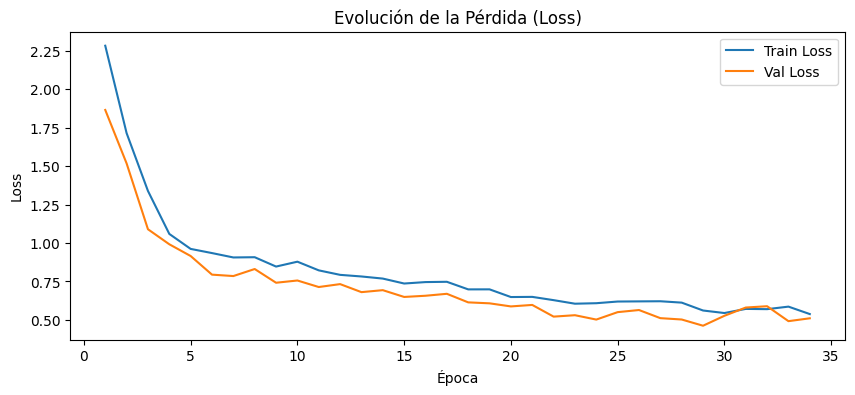

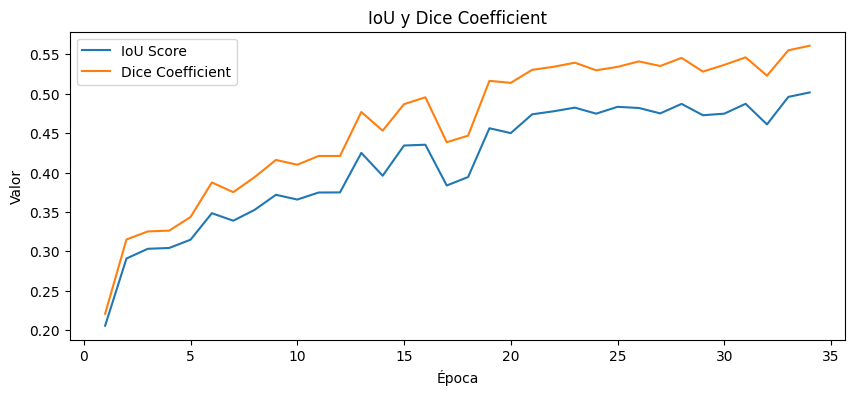

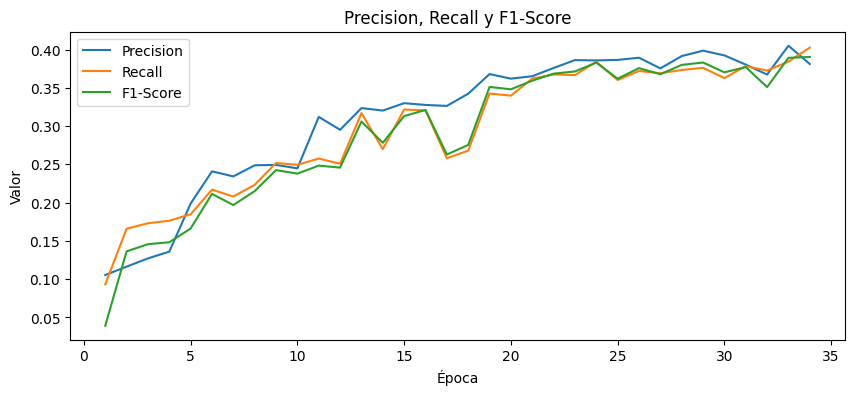

In [76]:
# Función para graficar métricas
def plot_metrics(train_losses, val_losses, iou_scores, dice_scores, precisions, recalls, f1_scores):
    epochs = range(1, len(train_losses) + 1)

    # Gráfica de Loss
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Evolución de la Pérdida (Loss)")
    plt.legend()
    plt.show()

    # Gráfica de IoU y Dice
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, iou_scores, label="IoU Score")
    plt.plot(epochs, dice_scores, label="Dice Coefficient")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.title("IoU y Dice Coefficient")
    plt.legend()
    plt.show()

    # Gráfica de Precision, Recall y F1-Score
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, precisions, label="Precision")
    plt.plot(epochs, recalls, label="Recall")
    plt.plot(epochs, f1_scores, label="F1-Score")
    plt.xlabel("Época")
    plt.ylabel("Valor")
    plt.title("Precision, Recall y F1-Score")
    plt.legend()
    plt.show()

# Graficar métricas
plot_metrics(train_losses, val_losses, iou_scores, dice_scores, precisions, recalls, f1_scores)

### Función para Visualizar la Máscara con los Colores Originales

In [77]:
def decode_mask(mask):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for color, class_idx in CLASS_COLORS.items():
        color_mask[mask == class_idx] = color  # Asignar color original

    return color_mask

### Mostrar Imagen y Máscara con los Colores Correctos

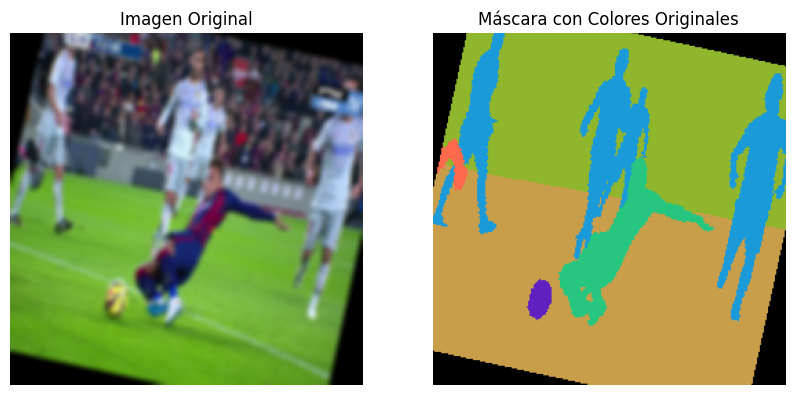

In [78]:
# Obtener una muestra del dataset
img, mask = dataset[0]

# Desnormalizar imagen
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img.permute(1, 2, 0).numpy()  # Convertir de tensor a numpy
img = (img * std) + mean  # Revertir normalización
img = np.clip(img, 0, 1)  # Asegurar valores en [0,1] para imshow()

# Quitar la dimensión extra de la máscara
mask = mask.squeeze(0).numpy()

# Convertir la máscara a colores originales
colored_mask = decode_mask(mask)

# Mostrar imagen y máscara corregida
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)  # Imagen original desnormalizada
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(colored_mask)  # Máscara con colores originales
ax[1].set_title("Máscara con Colores Originales")
ax[1].axis("off")

plt.show()

### Cargar el modelo guardado

In [79]:
model.load_state_dict(torch.load("../models/best_model.pth", map_location=device))

# Poner el modelo en modo evaluación
model.eval()

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(i

### Prediccion

In [80]:
def predict_image(model, image_path):
    model.eval()  # Ponemos el modelo en modo evaluación

    # Cargar la imagen
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transformar la imagen como en el entrenamiento
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    image = transform(image=image)['image'].unsqueeze(0).to(device)  # Agregar batch dimension

    # Obtener la predicción
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy().squeeze()

    # Mostrar la imagen original y la máscara predicha
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1])
    ax[0].set_title("Imagen Original")
    ax[0].axis("off")

    ax[1].imshow(decode_mask(predicted_mask))
    ax[1].set_title("Segmentación Predicha")
    ax[1].axis("off")

    plt.show()

In [81]:
num = '4'
test_image = f'../dataset/images/{num}.png'
test_mask = f'../dataset/masks/{num}.png'

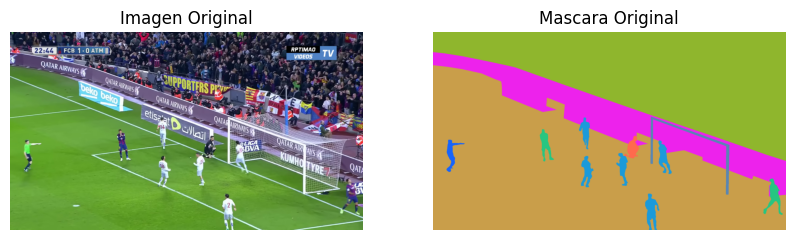

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.imread(test_image, cv2.IMREAD_COLOR)[:, :, ::-1])
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(cv2.imread(test_mask, cv2.IMREAD_COLOR)[:, :, ::-1])
ax[1].set_title("Mascara Original")
ax[1].axis("off")
plt.show()

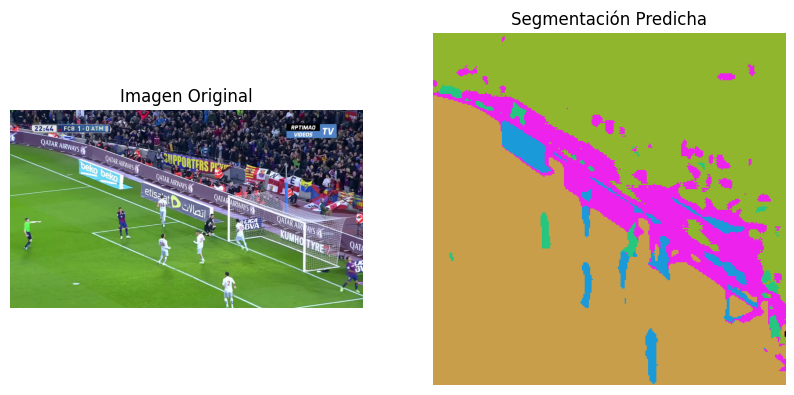

In [83]:
# Prueba con una imagen nueva
predict_image(model, test_image)

### Enviar mensaje de telegram

In [84]:
MENSAJE = "TERMINO EL JUPYTER"

# Parámetros del mensaje
parametros = {
    "chat_id": CHAT_ID,
    "text": MENSAJE
}

# Enviar el mensaje
respuesta = requests.get(URL, params=parametros)